In [1]:
%run lgs03a_data_unification.ipynb

## Correlation between mutations' predicted ddG and measured effect

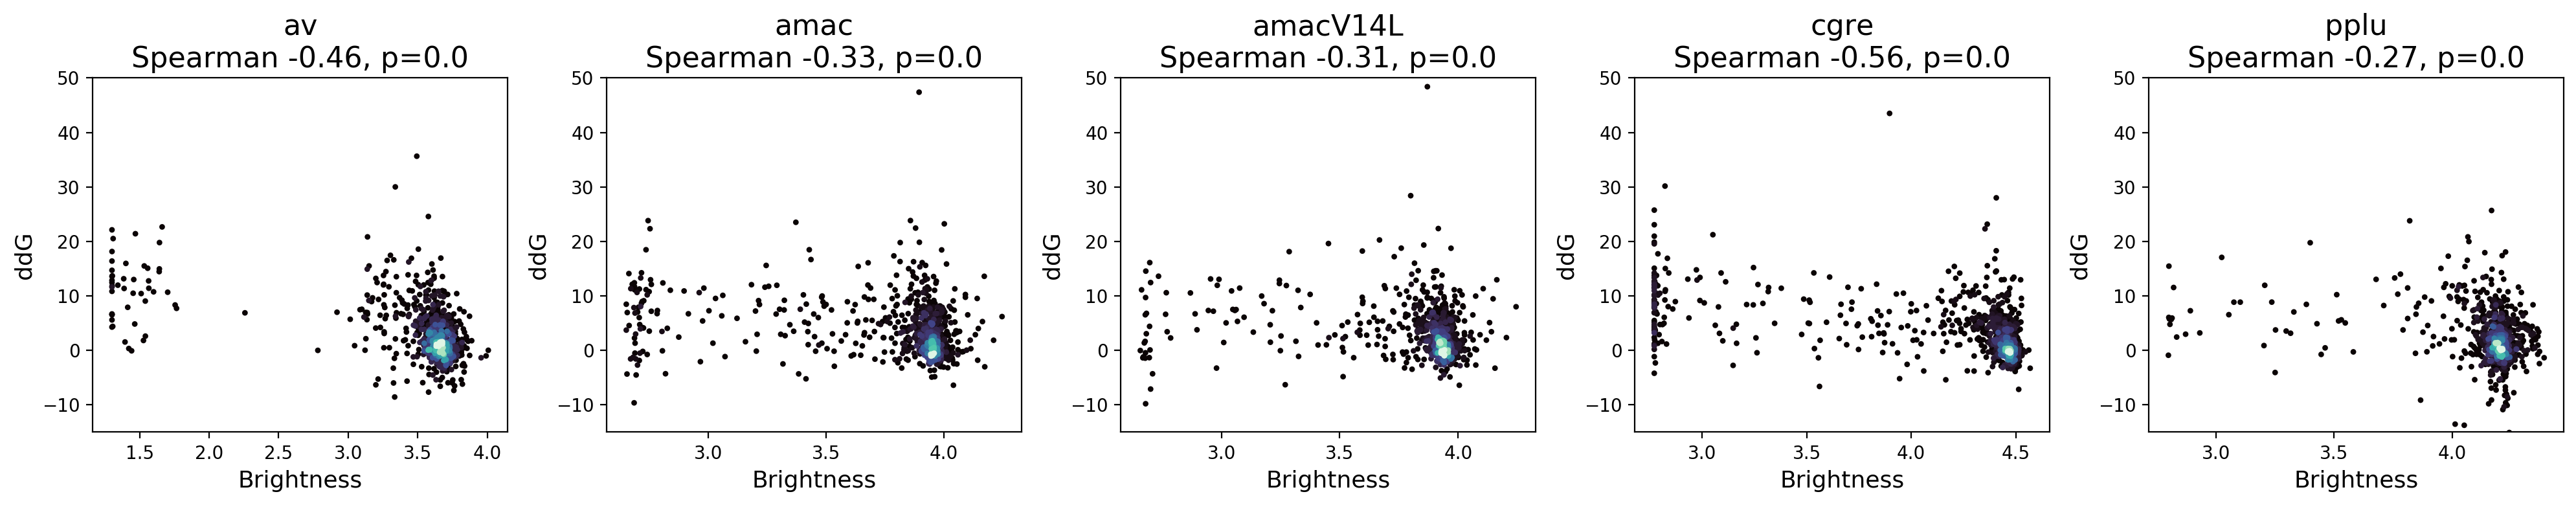

In [4]:
axes = subplots(nplots=5, nplots_per_row=5, height=4, width=4, dpi=200)
for ax,gene in zip(axes, ['av', 'amac', 'amacV14L', 'cgre', 'pplu']):
    plt.sca(ax)
    df = data_aa[singles_mask & eval(gene+'_mask') & ~chromomut_mask]
    df = df[~(df.aa_genotype_pseudo.str.contains('G|P'))]
    df = df[['brightness', 'ddG_prediction']].dropna()
    a = np.array(df['brightness'])
    b = np.array(df['ddG_prediction'])
    corr = scipy.stats.spearmanr(b,a,nan_policy='omit')
#     print(gene, corr)
#     print(scipy.stats.pearsonr(a,b))
    density_plot(a,b, s=10, cmap='mako')
    label_plot_axis(x='Brightness', y='ddG', 
                    t='%s\nSpearman %s, p=%s' % (gene, round(corr[0],2),  round(corr[1],5)))
    plt.ylim(-15,50)
plt.tight_layout()

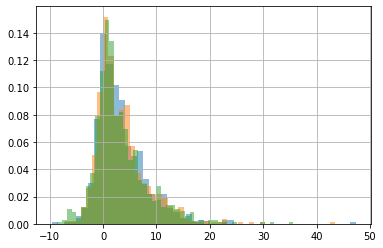

In [29]:
data_aa[amac_mask & ~(data_aa.aa_genotype_pseudo.str.contains('G|P'))]['ddG_prediction'].hist(bins=50, alpha=0.5, density=True)
# data_aa[pplu_mask & ~(data_aa.aa_genotype_pseudo.str.contains('G|P'))]['ddG_prediction'].hist(bins=50, alpha=0.5, density=True)
data_aa[cgre_mask & ~(data_aa.aa_genotype_pseudo.str.contains('G|P'))]['ddG_prediction'].hist(bins=50, alpha=0.5, density=True)
data_aa[av_mask & ~(data_aa.aa_genotype_pseudo.str.contains('G|P'))]['ddG_prediction'].hist(bins=50, alpha=0.5, density=True)

In [25]:
data_aa[pplu_mask & ~(data_aa.aa_genotype_pseudo.str.contains('G|P'))]['ddG_prediction'].median()

1.784

### Threshold effect

av MannwhitneyuResult(statistic=9447.0, pvalue=1.0578576565646762e-23)
amac MannwhitneyuResult(statistic=31823.0, pvalue=6.102484661663822e-09)
amacV14L MannwhitneyuResult(statistic=18866.5, pvalue=8.1135390116972e-06)
cgre MannwhitneyuResult(statistic=24568.5, pvalue=1.640809920913168e-34)
pplu MannwhitneyuResult(statistic=8208.5, pvalue=3.681341785655488e-12)


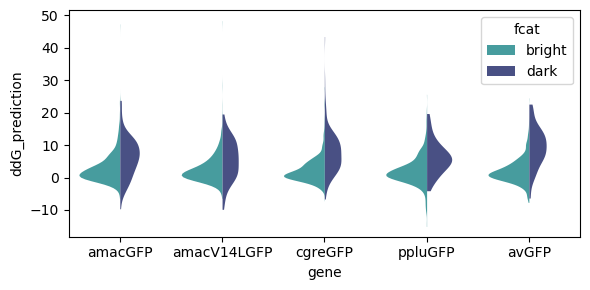

In [5]:
plt.figure(figsize=[6,3], dpi=100)

deleterious_cutoff = -0.5
neutral_cutoff = -0.2


df = data_aa[singles_mask & ~chromomut_mask]
df = df[~(df.aa_genotype_pseudo.str.contains('G|P'))].copy()
df['fcat'] = df['measured_effect'].apply(lambda x: 'bright' if x>neutral_cutoff 
                                         else 'dark' if x<deleterious_cutoff else 'meh')
sns.violinplot(data=df[df.fcat!='meh'], x='gene', y='ddG_prediction', hue='fcat', split=True, \
               linewidth=0, palette='mako_r', cut=0)

for gene in ['av', 'amac', 'amacV14L', 'cgre', 'pplu']:
    a = df[(df.gene==gene+'GFP')&(df['fcat']=='bright')]['ddG_prediction']
    b = df[(df.gene==gene+'GFP')&(df['fcat']=='dark')]['ddG_prediction']
    print(gene, scipy.stats.mannwhitneyu(a,b))

plt.tight_layout()

In [32]:
def get_mutposeffect(data, y_column, x_val, x_column='position', s_column='mutation', c_column='brightness'):
    df = data[data[x_column]==x_val]
    return list(df[y_column]), list(df[s_column]), list(df[c_column])

def set_x_coordinates(list_of_yvals, list_of_labels,  list_of_colors, y_distance_threshold, center_x, x_distance):
    '''Tries to find non-overlapping x coordinates for text-swarmplot'''
    yvals_to_labels = dict(zip(list_of_yvals, list_of_labels))
    yvals_to_colors = dict(zip(list_of_yvals, list_of_colors))
    list_of_yvals = sorted([x for x in list_of_yvals if str(x)!='nan'])
    list_of_xvals = [center_x for x in list_of_yvals]
    
    ref_y = 0
    multiplier = 1
#     original_x_distance = x_distance
    current_x_spacer = x_distance
        
    for i in range(1, len(list_of_yvals)):

        if abs(list_of_yvals[i] - list_of_yvals[ref_y]) < y_distance_threshold:
#             print(i, 'too close')
            list_of_xvals[i] += multiplier*current_x_spacer
            multiplier *= (-1)
            if multiplier== 1:
#                 print(i, 'multiply -1')
                current_x_spacer+=x_distance
        else:
            ref_y = i
            current_x_spacer = x_distance
#             print(i, 'new ref')

    return list_of_xvals, list_of_yvals, [yvals_to_labels[y] for y in 
                        list_of_yvals], [yvals_to_colors[y] for y in list_of_yvals]

In [39]:
def plot_positional_effects(gene, ylims=(-10,50), threshold=8):
    # positions not in PDB
    skip_cgre = [0,1,2,3,67,68,69,235]
    skip_pplu = [0,56,57,58]
    skip_av2 = [0,1,64,65,66]
    
    
    df = data_aa[singles_mask & eval(gene+'_mask')].copy()
    df['position'] = df['aa_genotype_native'].apply(lambda x: int(x[1:-1]))
    df['mutation'] = df['aa_genotype_native'].apply(lambda x: x[-1])
    
    colors_global = np.array(df['brightness'])
    colors_global = colors_global - min(colors_global)
    colors_global = 1. * colors_global / max(colors_global)
    colors_global = dict(zip(df['brightness'], colors_global))
    
    plt.figure(figsize=[175,5])
    labels = ['%s\n%s\n' % (str(i),aa) for i,aa in enumerate(eval(gene+'_wt'))]
    plt.xticks(range(0, len(labels)), labels)
    plt.xlim(-1, len(labels)+1)
    plt.ylim(ylims)
    label_plot_axis(x = 'Amino acid positions and wildtype states', fontsize_x = 16,
                    y = 'ddG prediction', fontsize_y = 14, fontsize_t = 18,)
    plt.axhline(threshold, color='r', linewidth=0.5)
    
    for pos in range(1,len(labels)):
        if pos not in eval('skip_'+gene):
            yvals, labels, colors = get_mutposeffect(df, y_column='ddG_prediction', 
                                         x_column = 'position', x_val=pos)
            xvals, yvals, labels, colors = set_x_coordinates(list_of_yvals=yvals, list_of_labels=labels, 
                                                             list_of_colors=colors, y_distance_threshold=1, 
                                                 center_x=pos, x_distance=0.2)
            colors = [colors_global[c] for c in colors]
            for i in range(len(yvals)):
                plt.text(x = xvals[i] , y = yvals[i], s=labels[i], size='small', color=matplotlib.cm.RdYlGn(colors[i]),
                       verticalalignment='center', horizontalalignment='center', weight='semibold')

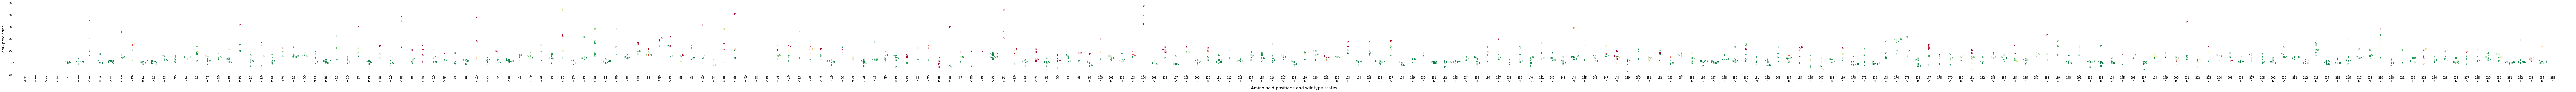

In [40]:
plot_positional_effects('cgre')